In [1]:
import os
import numpy as np
from scipy.misc import imread, imresize
from random import shuffle

In [2]:
IMAGE_DIR = '../data_collection_13_oct_4_c158/'
IMG_SIZE = (128, 128, 3)
TRAIN_DIR = '../data/train/train_set.npy'    
TEST_DIR = '../data/test/test_set.npy'  

# Preprocessing Data

In [3]:
def resize_and_label_img():
    data = []
    for img in os.listdir(IMAGE_DIR):
        angle = float(img.split("'")[1])
        img = imresize(imread(os.path.join(IMAGE_DIR, img)), IMG_SIZE) / 255
        data.append((img, angle))
    
    shuffle(data)
    return data

In [4]:
data = resize_and_label_img()

In [5]:
print(len(data))

441


In [6]:
def split_dataset():
    #data = resize_and_label_img()
    
    # Training dataset
    first_index, last_index = 0, int(len(data) * 0.90)
    train_set = data[first_index: last_index]
    
    # Test_dataset
    first_index = last_index
    test_set = data[first_index:]
    
    print(len(train_set), len(test_set))
#split_dataset()

In [7]:
def seperate_features_from_label(xs, ys, dataset):
    for data_point in dataset: 
        xs.append(data_point[0])
        ys.append(data_point[1])

# Dataset Reader

In [8]:
class DataReader(object):    
    def __init__(self):    
        self.train_set = np.load(TRAIN_DIR)
        print(len(self.train_set))
        self.xs = []
        self.ys = []
        
        # Seperating features xs and lable ys
        seperate_features_from_label(self.xs, self.ys, self.train_set)
    
    def train_batch(self, size=64):
        first_index, last_index = 0, size    
        while last_index <= len(self.train_set) + size:    
            yield self.xs[first_index: last_index], self.ys[first_index: last_index]    
            first_index, last_index = last_index, last_index + size 
    
    def cv_set(self):    
        cv_set = np.load(CV_DIR)    
        # Loading angle from cv.csv file    
        return cv_set   # [cv_set, csv]     
    
    def test_set(self):    
        test_set = np.load(TEST_DIR)    
        xs = []
        ys = []
        seperate_features_from_label(xs, ys, test_set)
        # loading angle from test.csv file    
        return xs, ys  # [test_set, csv]    

In [9]:
data_reader = DataReader()

432


In [10]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [11]:
counter = 0
for train_batch_set in data_reader.train_batch(1):
    if counter >= 432:
        print(np.array(train_batch_set[0]).shape, np.array(train_batch_set[1]).shape)
    counter += 1


(0,) (0,)


# Training Phase

In [12]:
import tensorflow as tf 

In [13]:
def weight_variable(shape):                                                      
    initializer = tf.contrib.layers.xavier_initializer_conv2d()                  
    initial = initializer(shape=shape)                                           
    return tf.Variable(initial)                                                  
                                                                                 
                                                                                 
def bias_variable(shape):                                                        
    initial = tf.constant(0.1, shape=shape)                                      
    return tf.Variable(initial)                                                  
                                                                                 
                                                                                 
def conv2d(x, W, stride):                                                        
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')    
                                                                                 
                                                                                 
def max_pool2x2(x):                                                              
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],                                 
                          strides=[1, 2, 2, 1], padding='SAME')  

In [14]:
class ConvModel1(object):     
    def __init__(self, is_training=True):                                        
        x = tf.placeholder(tf.float32, shape=[None, 128, 128, 3], name='x')      
        y_ = tf.placeholder(tf.float32, shape=[None, 1])                         
        x_image = x                                                              
                                                                                 
        # Conv layer 1                                                           
        self.W_conv1 = weight_variable([3, 3, 3, 32])                            
        self.b_conv1 = bias_variable([32])                                       
        self.h_conv1 = max_pool2x2(tf.nn.relu(conv2d(x_image, self.W_conv1, 1) + self.b_conv1))
                                                                                 
        # Conv layer 2                                                           
        self.W_conv2 = weight_variable([3, 3, 32, 64])                           
        self.b_conv2 = bias_variable([64])                                       
        self.h_conv2 = max_pool2x2(tf.nn.relu(conv2d(self.h_conv1, self.W_conv2, 1) + self.b_conv2))
                                                                                 
        # Conv layer 3                                                           
        self.W_conv3 = weight_variable([3, 3, 64, 128])                          
        self.b_conv3 = bias_variable([128])                                      
        self.h_conv3 = max_pool2x2(tf.nn.relu(conv2d(self.h_conv2, self.W_conv3, 1) + self.b_conv3))
                                                                                 
        # Fully Connect layer 1                                                  
        self.W_fc1 = weight_variable([16*16*128, 1024])                          
        self.b_fc1 = bias_variable([1024])                                       
                                                                                 
        self.h_conv3_flat = tf.reshape(self.h_conv3, [-1, 16*16*128])            
        self.h_fc1 = tf.nn.relu(tf.matmul(self.h_conv3_flat, self.W_fc1) + self.b_fc1)
        print("Fc1 output shape: ", self.h_fc1)                                  
                                                                                 
        # Output layer                                                           
        self.W_fc2 = weight_variable([1024, 1])                                  
        self.b_fc2 = bias_variable([1])                                          
        h_fc2 = tf.matmul(self.h_fc1, self.W_fc2) + self.b_fc2                   
        print("Final output shape: ", h_fc2)                                     
                                                                                 
        self.x = x                                                               
        self.y_ = y_                                                             
        self.y = h_fc2      

In [15]:
sess = tf.Session()

In [16]:
model = ConvModel1()                                                         

Fc1 output shape:  Tensor("Relu_3:0", shape=(?, 1024), dtype=float32)
Final output shape:  Tensor("add_4:0", shape=(?, 1), dtype=float32)


In [17]:
data_reader = DataReader()

432


In [18]:
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))))         
train_step = tf.train.AdamOptimizer(10e-3).minimize(loss)  

In [19]:
sess.run(tf.global_variables_initializer())  

In [20]:
import matplotlib.pyplot as plt

In [21]:
for batch_i in data_reader.train_batch(64):
    print(len(batch_i[0]))

64
64
64
64
64
64
48


In [27]:
costs = []
for epoch in range(100):
    counter = 0
    for train_batch in data_reader.train_batch(32):
        #p1rint("Counter: {}".format(counter))
        xs = np.array(train_batch[0])
        #print("xs length: ", len(xs))
        #print("xs passed:")
        ys = np.array(train_batch[1]).reshape([len(train_batch[1]), 1])
        #print("ys length: ", len(ys))
        #print("ys passed")
        #print("image: {}, x shape: {}, y shape: {}".format(counter, xs.shape, ys.shape))
        # print(xs)
        sess.run(train_step, feed_dict={model.x: xs, model.y_: ys})
        #print("Train passed:")
        train_error = loss.eval(session=sess, feed_dict={model.x: xs,  model.y_: ys})
                                                                                 
    if epoch % 10 == 0:                                                                     
        print("Step: %d, train loss: %g" % (epoch, train_error))
        costs.append(train_error)
                                                                                 
#checkpoint_path = os.path.join(CKPT_DIR, CKPT_FILE)                          
#filename = saver.save(sess, checkpoint_path)                                 
#print('Model saved in file: %s' % filename)   

Step: 0, train loss: 7.69963
Step: 10, train loss: 3.23576
Step: 20, train loss: 11.6841
Step: 30, train loss: 5.10057
Step: 40, train loss: 2.67917
Step: 50, train loss: 1.06684
Step: 60, train loss: 3.69885
Step: 70, train loss: 1.97931
Step: 80, train loss: 2.89156
Step: 90, train loss: 2.41979


NameError: name 'learning_rate' is not defined

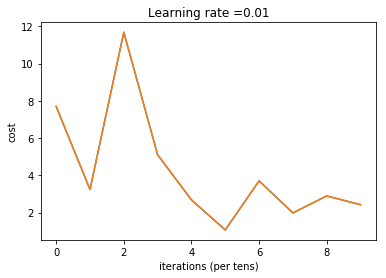

In [28]:
# plot learning curve
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(10e-3))
plt.show()

## Testing the accuracy

In [29]:
xs , ys = data_reader.test_set()

In [33]:
test_error = loss.eval(session=sess, feed_dict={model.x: np.array(xs), model.y_: np.array(ys).reshape([len(ys), 1])})
print("Test Error: {}".format(test_error))

Test Error: 3.563483238220215
